# Simulations and results

## Methods
1. Models - FNO
2. UQ - LSCI, UQNO, BAND, CONF

## Comparisons
1. White noise control runs (small data).
    1. Homoscedastic
    2. Heterskedastic 
3. Forced Navier Stokes emulation (medium data)
    1. coverage (marginal and local)
    2. average width
    3. plot
5. Day ahead weather forecasting (big data)
    1. coverage (marginal and local)
    2. average width
    3. plot

## Demonstrations
1. Empirical width and local coverage vs sampled ensemble size (note when becomes risk controlling)
2. Sample approximation skill vs number of proj and samples (Wasserstein, CRPS, etc.)
3. covariate, semantic, and predictive localization


In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, grad, jit, random
from flax import nnx
import optax

import matplotlib
import matplotlib.pyplot as plt

import zarr
import xarray as xr

import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

In [2]:
def warp01(cdf):
    _min = jnp.min(cdf, axis = 0)[None,]
    _max = jnp.max(cdf, axis = 0)[None,]
    return (cdf - _min) / (_max - _min)

def local_weights(yval, ytest, frac = 0.1):
    dmat = jnp.max(jnp.abs(yval - ytest), axis = 1)
    quant = jnp.quantile(dmat, frac, axis = 0)
    indx = dmat < quant
    inner_max = jnp.max(dmat * indx)
    dmat = inner_max - dmat
    w = dmat * indx
    return w / jnp.sum(w, axis = 0)[None,]
local_weights = jit(vmap(local_weights, (None, 0, None)))

def local_cdf(rval, q, weight):
    lcdf = jnp.sum(weight * (rval < q))
    return lcdf
local_cdf = jit(local_cdf)
local_cdf = jit(vmap(local_cdf, (None, None, 0)))

def local_quantile(rval, p, weight):
    rval_sort = jnp.sort(rval, axis = 0)
    lcdf = jnp.sum(weight[None,:] * (rval[None,:] < rval_sort[:,None]), axis = 1)
    lcdf = warp01(lcdf)
    ind = jnp.argmax(1.0*(lcdf >= p))
    return rval_sort[ind]
local_quantile = jit(local_quantile)
local_quantile_vmap = jit(vmap(local_quantile, (1, None, None)))
local_quantile_proj = vmap(local_quantile_vmap, (None, None, 0))

def local_tukey(rval, q, weight):
    lcdf_l = jnp.sum(weight * (rval < q))
    lcdf_r = jnp.sum(weight * (rval > q))
    return 2 * jnp.min(jnp.array([lcdf_l, lcdf_r]))
local_tukey = jit(local_tukey)
local_tukey_vmap = vmap(local_tukey, (1, 1, None))

local_tukey_self = vmap(local_tukey, (None, 0, None))
local_tukey_self = jit(vmap(local_tukey_self, (1, 1, None)))

def warped_unif(rng, a, b):
    u = jax.random.uniform(rng)
    return (b - a) * u + a

def conformal_resample(rng, x, w):
    phi = local_quantile(x, warped_unif(rng, 0.0, 1.0), w)
    return phi
conformal_resample = vmap(conformal_resample, (0, 1, None))

def conformal_ens(rng, x, w):
    rngs = random.split(rng, x.shape[1])
    return conformal_resample(rngs, x, w)
conformal_ens = vmap(conformal_ens, (0, None, None))

In [3]:
def lsci_sample(residuals, local_weight, pca_state, alpha, nsamp, rng = random.PRNGKey(0)):
    res_proj = pcax.transform(pca_state, residuals)
    rngs = random.split(rng, nsamp)
    phi_t = conformal_ens(rngs, res_proj, local_weight)
    ens_t = pcax.recover(pca_state, phi_t)
    
    dval = jnp.mean(local_tukey_self(res_proj, res_proj, local_weight), axis = 0)
    qval = jnp.quantile(dval, alpha)
    dphi = jnp.mean(local_tukey_self(res_proj, phi_t, local_weight), axis = 0)
    return ens_t[dphi > qval]

In [4]:
# conformal prediction bands (supremum method)
def modulator(r):
    mod_r = jnp.max(jnp.abs(r), axis = 0)
    return mod_r / jnp.mean(mod_r)

def band_nonconf(r, s):
    mod_r = r / s[None,:]
    return jnp.max(jnp.abs(mod_r), axis = 1)

def band_predset(r ,s):
    mod_r = s[None,:]
    cval_band = band_nonconf(rval)[:,None]
    return cval_band * mod_r

In [5]:
def split_cal(yval_hat, yval):
    nval = yval.shape[0]
    nval2 = yval.shape[0]//2

    yval = yval.reshape(nval, -1)
    yval_hat = yval_hat.reshape(nval, -1)
    
    rval = yval - yval_hat
    rval1 = rval[:nval2]
    rval2 = rval[nval2:]
    yval1 = yval[:nval2]
    yval2 = yval[nval2:]
    yval_hat1 = yval_hat[:nval2]
    yval_hat2 = yval_hat[nval2:]
    return rval1, rval2, yval1, yval2, yval_hat1, yval_hat2

def project_cal(rval1, rval2, yval_hat2, nproj, pca_state):
    pca_state = pcax.fit(rval1, n_components=nproj)
    rval_proj = pcax.transform(pca_state, rval2)
    yval_hat_proj = pcax.transform(pca_state, yval_hat2)
    return rval_proj, yval_hat_proj

def project_test(ytest_hat, ytest = None, state = None):
    ntest = ytest_hat.shape[0]

    # reshape and compute residuals
    ytest_hat = ytest_hat.reshape(ntest, -1)
    ytest_hat_proj = pcax.transform(pca_state, ytest_hat)

    if ytest is not None:
        ytest = ytest.reshape(ntest, -1)
        rtest = ytest - ytest_hat
        rtest_proj = pcax.transform(pca_state, rtest)
        return rtest, rtest_proj, ytest_hat_proj

    return ytest_hat_proj

In [6]:
### compute all bands
def lsci_band(residuals, local_weight, pca_state, alpha, nsamp, rng = random.PRNGKey(0)):
    lsci_conf = lsci_sample(residuals, local_weight, pca_state, alpha, nsamp, rng)
    lsci_lower = jnp.min(lsci_conf, axis = 0)
    lsci_upper = jnp.max(lsci_conf, axis = 0)
    return lsci_lower, lsci_upper

def conf_band(residuals, pca_state, alpha):
    res_proj = pcax.transform(pca_state, residuals)
    dval_conf = jnp.mean(local_tukey_self(res_proj, res_proj, 1/res_proj.shape[0]), axis = 0)
    qval_conf = jnp.quantile(dval_conf, alpha)
    conf_ens = pcax.recover(pca_state, res_proj[dval_conf > qval_conf])
    conf_lower = jnp.min(conf_ens, axis = 0)
    conf_upper = jnp.max(conf_ens, axis = 0)
    return conf_lower, conf_upper

def supr_band(residuals, alpha):
    s_fn = modulator(residuals)
    cval_supr = band_nonconf(residuals, s_fn)[:,None]
    qval_supr = jnp.quantile(cval_supr, 1-alpha)
    band_supr = (qval_supr * s_fn)[None,:]
    return -band_supr, band_supr

def uqno_band(ytest_quant, lam_uqn):
    band_uqn = (lam_uqn * ytest_quant)
    return -band_uqn, band_uqn

In [7]:
def risk_control(lower, upper, residual):
    return jnp.mean((residual > lower)*(residual < upper))

In [8]:
def split_data(data, lag, horizon):
    horizon = horizon-1
    y_t = np.moveaxis(data[(lag + horizon):][:,None], 1, 3)
    x_t = np.stack([data[(lag-i-1):(-(i+1+horizon))] for i in range(lag)], axis = 3)
    return x_t, y_t

In [9]:
class Block(nnx.Module):
    def __init__(self, dim, dim_out, rngs = nnx.Rngs):
        self.proj = nnx.Conv(dim, dim_out, (3, 3), padding = 'CIRCULAR', rngs = rngs)
        self.norm = nnx.BatchNorm(dim_out, rngs = rngs)

    def __call__(self, x):
        x = self.proj(x)
        x = self.norm(x)
        return nnx.silu(x)

class ResnetBlock(nnx.Module):
    def __init__(self, dim, dim_out, rngs = nnx.Rngs):
        self.block1 = Block(dim, dim_out, rngs = rngs)
        self.block2 = Block(dim_out, dim_out, rngs = rngs)
        self.block3 = Block(dim_out, dim_out, rngs = rngs)
        self.res_conv = nnx.Conv(dim, dim_out, (1, 1), rngs = rngs)

    def __call__(self, x):
        h = self.block1(x)
        h = self.block2(h)
        h = self.block3(h)
        return h + self.res_conv(x)

class ClimateNO(nnx.Module):
    def __init__(self, lag, rngs = nnx.Rngs):
        self.enc = nnx.Conv(lag, 30, (1, 1), rngs = rngs)
        self.res1 = ResnetBlock(30, 32, rngs = rngs)
        self.res2 = ResnetBlock(32, 16, rngs = rngs)
        self.res3 = ResnetBlock(16, 1, rngs = rngs)
        self.dec = nnx.Conv(1, 1, (1, 1), rngs = rngs)

    def __call__(self, x):
        m = jnp.mean(x, axis = 3)[:,:,:,None]
        h = self.enc(x - m)
        h = self.res1(h)
        h = self.res2(h)
        h = self.res3(h)
        h = self.dec(h)
        return m + h

class ClimateUQNO(nnx.Module):
    def __init__(self, lag, rngs = nnx.Rngs):
        self.enc = nnx.Conv(lag, 30, (1, 1), rngs = rngs)
        self.res1 = ResnetBlock(30, 32, rngs = rngs)
        self.res2 = ResnetBlock(32, 16, rngs = rngs)
        self.res3 = ResnetBlock(16, 1, rngs = rngs)
        self.dec = nnx.Conv(1, 1, (1, 1), rngs = rngs)

    def __call__(self, x):
        m = jnp.mean(x, axis = 3)[:,:,:,None]
        h = self.enc(x - m)
        h = self.res1(h)
        h = self.res2(h)
        h = self.res3(h)
        h = self.dec(h)
        return nnx.softplus(m + h)

In [10]:
dval = np.load('./data/era5_val_small.npy', mmap_mode='r+')
dtest = np.load('./data/era5_test_small.npy', mmap_mode='r+')

In [11]:
import os
import orbax.checkpoint as ocp

# extract state
lag = 24
horizon = 4
batch = 64
groups = 10
niter = int(5200/batch)

checkpointer = ocp.StandardCheckpointer()

model = ClimateNO(lag, rngs=nnx.Rngs(0))
tree, state = nnx.split(model)
state_rec = checkpointer.restore(os.getcwd() + '/models/' + 'era5_small_state', state)
model = nnx.merge(tree, state_rec)

model_quant = ClimateNO(lag, rngs=nnx.Rngs(0))
tree, state = nnx.split(model_quant)
state_rec = checkpointer.restore(os.getcwd() + '/models/' + 'era5_small_quant_state', state)
model_quant = nnx.merge(tree, state_rec)

In [12]:
lag = 24
horizon = 4
batch = 100
groups = 2
m = dval.shape[0]//groups
niter = int(m/batch)

yval_hat = []
yval_quant = []
yval = []
for g in trange(groups):
    xval_g, yval_g = split_data(dval[(g*m):((g+1)*m)], lag, horizon)

    for i in trange(niter, leave = False):
        xt = xval_g[(i*batch):((i+1)*batch)]
        yval_hat.append(model(xt))
        yval_quant.append(model_quant(xt))

    yval.append(yval_g)

yval_quant = np.concat(yval_quant)
yval_hat = np.concat(yval_hat)
yval = np.concat(yval)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
# UQNO lambda estimate
alpha = 0.1
delta = 0.1
m = 32*64
tau = 1.1 * jnp.sqrt(-jnp.log(delta)/(2*m))
sg = jnp.abs(yval - yval_hat) / yval_quant
sg = jnp.quantile(sg, 1-alpha+tau, axis = (1,2,3))
nval = sg.shape[0]

adj_alpha = 1 - jnp.ceil((nval + 1) * (delta - jnp.exp(-2*m*tau**2)))/nval
lam_uqno = jnp.quantile(sg, adj_alpha)
lam_uqno

Array(0.27486604, dtype=float32)

In [14]:
del yval_quant

In [15]:
m = dtest.shape[0]//groups

ytest_hat = []
ytest_quant = []
ytest = []
for g in trange(groups):
    xtest_g, ytest_g = split_data(dtest[(g*m):((g+1)*m)], lag, horizon)

    for i in trange(niter, leave = False):
        xt = xtest_g[(i*batch):((i+1)*batch)]
        ytest_hat.append(model(xt))
        ytest_quant.append(model_quant(xt))

    ytest.append(ytest_g)

ytest_quant = np.concat(ytest_quant)
ytest_hat = np.concat(ytest_hat)
ytest = np.concat(ytest)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
np.sqrt(np.mean((yval - yval_hat)**2)), np.sqrt(np.mean((ytest - ytest_hat)**2))

(np.float64(1.6579186674338238), np.float64(1.659476701256655))

In [17]:
nval = yval.shape[0]
nval2 = yval.shape[0]//2
ntest = ytest_hat.shape[0]
nlat, nlon = 32, 64
nproj = 300

# split calibration dataset
yval = yval.reshape(nval, -1)
yval_hat = yval_hat.reshape(nval, -1)
rval = yval - yval_hat
rval1, rval2, yval1, yval2, yval_hat1, yval_hat2 = split_cal(yval_hat, yval)

# process test dataset
ytest = ytest.reshape(ntest, -1)
ytest_hat = ytest_hat.reshape(ntest, -1)
ytest_quant = ytest_quant.reshape(ntest, -1)
rtest = ytest - ytest_hat

# project calibration and test
pca_state = pcax.fit(rval1, n_components=nproj)
rval_proj2, yval_hat_proj2 = project_cal(rval1, rval2, yval_hat2, nproj, pca_state)
rtest, rtest_proj, ytest_hat_proj = project_test(ytest_hat, ytest, pca_state)

In [28]:
gamma1 = 0.05
gamma2 = 0.5
alpha = 0.1
alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval2 + 1))/(gamma1*nval2)
alpha2 = 1 - jnp.ceil((1-alpha) * (gamma2*nval2 + 1))/(gamma2*nval2)

lweight1 = local_weights(pcax.transform(pca_state, yval_hat2), 
                        pcax.transform(pca_state, ytest_hat), 
                        gamma1)
lweight2 = local_weights(pcax.transform(pca_state, yval_hat2), 
                        pcax.transform(pca_state, ytest_hat), 
                        gamma2)

In [29]:
# Weather risk control

lsc1_rc = []
lsc1_width = []

lsc2_rc = []
lsc2_width = []

uqn1_rc = []
uqn1_width = []

uqn2_rc = []
uqn2_width = []

conf_rc = []
conf_width = []

supr_rc = []
supr_width = []

uqn1_lower, uqn1_upper = uqno_band(ytest_quant, lam_uqno)
uqn2_lower, uqn2_upper = uqno_band(ytest_quant, 0.75*lam_uqno)
conf_lower, conf_upper = conf_band(rval2, pca_state, alpha)
supr_lower, supr_upper = supr_band(rval2, alpha)

# for i in trange(ytest.shape[0]):
for i in trange(0, ytest.shape[0], 20):
    # LSCI (sparse)
    lsc1_lower, lsc1_upper = lsci_band(rval2, lweight1[i], pca_state, alpha1, 2000)
    lsc1_rc.append(risk_control(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # LSCI (dense)
    lsc2_lower, lsc2_upper = lsci_band(rval2, lweight2[i], pca_state, alpha2, 2000)
    lsc2_rc.append(risk_control(lsc2_lower, lsc2_upper, rtest[i]))
    lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))

    # UQNO (original)
    uqn1_rc.append(risk_control(uqn1_lower[i], uqn1_upper[i], rtest[i]))
    uqn1_width.append(jnp.mean(uqn1_upper[i] - uqn1_lower[i]))

    # UQNO (adjusted)
    uqn2_rc.append(risk_control(uqn2_lower[i], uqn2_upper[i], rtest[i]))
    uqn2_width.append(jnp.mean(uqn2_upper[i] - uqn2_lower[i]))

    # CONF 
    conf_rc.append(risk_control(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.mean(conf_upper - conf_lower))

    # SUPR
    supr_rc.append(risk_control(supr_lower, supr_upper, rtest[i]))
    supr_width.append(jnp.mean(supr_upper - supr_lower))

uqn1_rc = np.array(uqn1_rc)
uqn2_rc = np.array(uqn2_rc)
conf_rc = np.array(conf_rc)
supr_rc = np.array(supr_rc)
lsc1_rc = np.array(lsc1_rc)
lsc2_rc = np.array(lsc2_rc)

uqn1_width = np.array(uqn1_width)
uqn2_width = np.array(uqn2_width)
conf_width = np.array(conf_width)
supr_width = np.array(supr_width)
lsc1_width = np.array(lsc1_width)
lsc2_width = np.array(lsc2_width)

  0%|          | 0/998 [00:00<?, ?it/s]

In [30]:
# fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 4))
# ax[0].plot(uqno1_rc)
# ax[0].plot(uqno2_rc)
# ax[0].plot(conf_rc)
# ax[0].plot(supr_rc)
# ax[0].plot(lsci_rc)
# ax[0].axhline(0.9)

# ax[1].plot(uqno1_width)
# ax[1].plot(uqno2_width)
# ax[1].plot(conf_width)
# ax[1].plot(supr_width)
# ax[1].plot(lsci_width)

# plt.show()

In [31]:
# nrange = (100, 1000, 10000, 20000, 30000)
# rc = []
# mx = []
# for n in nrange:
#     lsci_lower, lsci_upper = lsci_band(rval2, lweight[0], pca_state, alpha, n)
#     rc.append(risk_control(lsci_lower, lsci_upper, rtest[0]))
#     mx.append(jnp.quantile(lsci_upper, 0.99))

In [32]:
# # plt.plot(nrange, rc)
# plt.plot(nrange, mx)
# plt.axhline(0.9)

In [33]:
noise_sd = np.std(rtest, axis = 1)[0:-1:20]

risk = np.mean(uqn1_rc > 0.90), \
       np.mean(uqn2_rc > 0.90), \
       np.mean(conf_rc > 0.90), \
       np.mean(supr_rc > 0.90), \
       np.mean(lsc1_rc > 0.90), \
       np.mean(lsc2_rc > 0.90)

width = np.mean(uqn1_width), \
        np.mean(uqn2_width), \
        np.mean(conf_width), \
        np.mean(supr_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = np.abs(np.corrcoef([noise_sd, uqn1_rc])[0,1]), \
           np.abs(np.corrcoef([noise_sd, uqn2_rc])[0,1]), \
           np.abs(np.corrcoef([noise_sd, conf_rc])[0,1]), \
           np.abs(np.corrcoef([noise_sd, supr_rc])[0,1]), \
           np.abs(np.corrcoef([noise_sd, lsc1_rc])[0,1]), \
           np.abs(np.corrcoef([noise_sd, lsc2_rc])[0,1])

width_cor = np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, uqn2_width])[0,1], \
            0, \
            0, \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk, width, risk_cor, width_cor]).T

In [34]:
for i in range(6):
    for j in range(len(metrics[0])):
        print(f'{metrics[i, j]:.03f}', end = ' ')
    print('\r')

0.992 10.258 0.160 -0.141 
0.783 7.694 0.270 -0.141 
1.000 11.837 0.195 0.000 
1.000 17.159 0.355 0.000 
0.964 6.690 0.305 0.289 
0.979 6.761 0.385 0.083 


In [88]:
lsci_rc = []
uqno_rc = []
lsci_width = []
uqno_width = []

uqno_lower, uqno_upper = uqno_band(ytest_quant, 0.75*lam_uqno)

for i in trange(100):
    lsci_lower, lsci_upper = lsci_band(rval2, lweight[i], pca_state, alpha, 1000)
    lsci_rc.append(risk_control(lsci_lower, lsci_upper, rtest[i]))
    lsci_width.append(jnp.median(lsci_upper - lsci_lower))

    uqno_rc.append(risk_control(uqno_lower[i], uqno_upper[i], rtest[i]))
    uqno_width.append(jnp.median(uqno_upper[i] - uqno_lower[i]))

  0%|          | 0/100 [00:00<?, ?it/s]

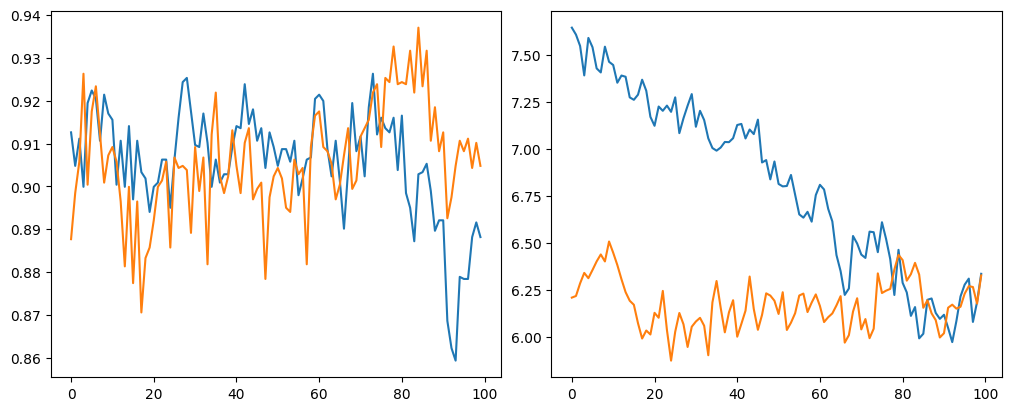

In [89]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 4))
ax[0].plot(uqno_rc)
ax[0].plot(lsci_rc)

ax[1].plot(uqno_width)
ax[1].plot(lsci_width)

plt.show()

In [61]:
lsci_lower, lsci_upper = lsci_band(rval2, lweight[100], pca_state, alpha, 1000)
risk_control(lsci_lower, lsci_upper, rtest[100])

Array(0.90722656, dtype=float32)

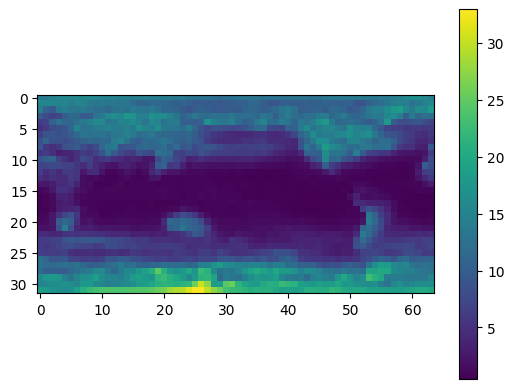

In [34]:
plt.imshow((lsci_upper - lsci_lower).reshape(nlat, nlon))
plt.colorbar()
plt.show()

In [39]:
### standard conformal
conf_lower, conf_upper = conf_band(rval2, pca_state, alpha)
risk_control(conf_lower, conf_upper, rtest[100])

Array(0.9453125, dtype=float32)

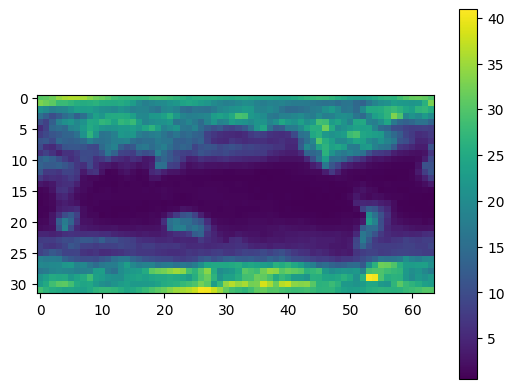

In [40]:
plt.imshow((conf_upper - conf_lower).reshape(nlat, nlon))
plt.colorbar()
plt.show()

In [41]:
supr_lower, supr_upper = supr_band(rval2, alpha)
risk_control(supr_lower, supr_upper, rtest[100])

Array(1., dtype=float32)

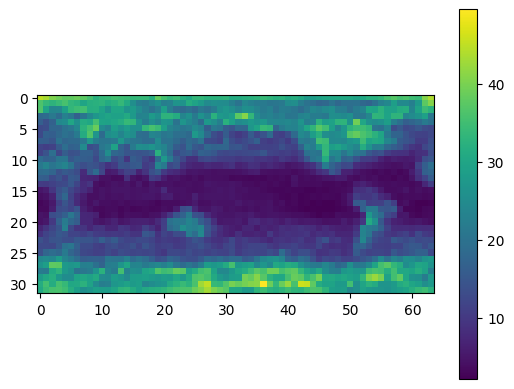

In [38]:
plt.imshow((supr_upper - supr_lower).reshape(nlat, nlon))
plt.colorbar()
plt.show()

In [64]:
uqno_lower, uqno_upper = uqno_band(ytest_quant, lam_uqno)
risk_control(uqno_lower[100], uqno_upper[100], rtest[100])

Array(0.94873047, dtype=float32)

In [63]:
uqno_lower.shape

(19946, 2048)

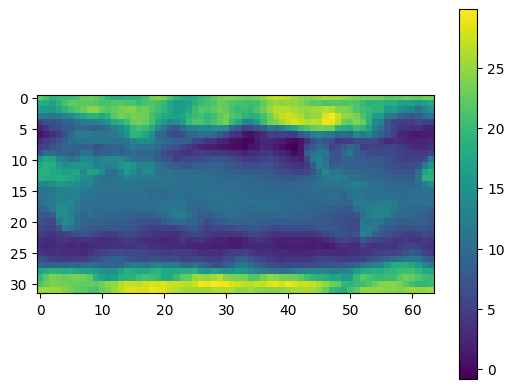

In [43]:
plt.imshow((uqno_upper[0] - uqno_lower[0]).reshape(nlat, nlon))
plt.colorbar()
plt.show()

In [54]:
jnp.mean(lsci_upper-lsci_lower)

Array(7.8993726, dtype=float32)

In [55]:
jnp.mean(conf_upper-conf_lower)

Array(11.829764, dtype=float32)

In [56]:
jnp.mean(supr_upper-supr_lower)

Array(17.158909, dtype=float32)

In [57]:
jnp.mean(uqno_upper-uqno_lower)

Array(10.216893, dtype=float32)

In [106]:
# means = jnp.array([jnp.mean(lsci(lweight[i], sampling_state, 100), axis = 0) for i in trange(ntest)])

  0%|          | 0/19946 [00:00<?, ?it/s]

In [ ]:
# rngs = random.split(random.PRNGKey(0), 2000)
# phi_t = conformal_ens(rngs, rval_proj2, lweight[0])
# ens_t = pcax.recover(state, phi_t).reshape(-1, 32, 64)

In [25]:
# # val
# nval = yval.shape[0]
# nval2 = yval.shape[0]//2
# nproj = 100

# # reshape and compute residuals
# yval = yval.reshape(nval, -1)
# yval_hat = yval_hat.reshape(nval, -1)

# rval = yval - yval_hat
# rval1 = rval[:nval2]
# rval2 = rval[nval2:]

# # project
# import pcax
# state = pcax.fit(rval1, n_components=nproj)

# # yval_proj = pcax.transform(state, yval)
# rval_proj2 = pcax.transform(state, rval2)

# # yval_hat_proj1 = pcax.transform(state, yval_hat[:nval2])
# yval_hat_proj2 = pcax.transform(state, yval_hat[nval2:])

In [16]:
# # test
# ntest = ytest.shape[0]

# # reshape and compute residuals
# ytest = ytest.reshape(ntest, -1)
# ytest_hat = ytest_hat.reshape(ntest, -1)
# rtest = ytest - ytest_hat

# # ytest_proj = pcax.transform(state, ytest)
# rtest_proj = pcax.transform(state, rtest)
# ytest_hat_proj = pcax.transform(state, ytest_hat)

In [20]:
qval = []
for i in trange(10):
# for i in trange(1000):
    dval = jnp.mean(local_tukey_self(rval_proj2, rval_proj2, lweight[i]), axis = 0)
    qval.append(jnp.quantile(dval, alpha))
qval = jnp.array(qval)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
dtest = []
for i in trange(ntest):
# for i in trange(1000):
    d = jnp.mean(local_tukey_vmap(rval_proj2, rtest_proj[i:(i+1)], lweight[i]))
    dtest.append(d)
dtest = jnp.array(dtest)

In [97]:
jnp.mean(dtest >= qval)

Array(0.9131154, dtype=float32)

In [149]:
# ordinary conformal
dval_conf = jnp.mean(local_tukey_self(rval_proj2, rval_proj2, 1/rval_proj2.shape[0]), axis = 0)
qval_conf = jnp.quantile(dval_conf, alpha)

In [150]:
dtest_conf = []
for i in trange(ntest):
# for i in trange(1000):
    d = jnp.mean(local_tukey_vmap(rval_proj2, rtest_proj[i:(i+1)], 1/rval_proj2.shape[0]))
    dtest_conf.append(d)
dtest_conf = jnp.array(dtest_conf)

  0%|          | 0/19946 [00:00<?, ?it/s]

In [151]:
jnp.mean(dtest_conf >= qval_conf)

Array(0.8841873, dtype=float32)

In [153]:
s_fn = modulator(rval)
cval_supr = band_nonconf(rval, s_fn)[:,None]
ctest_supr = band_nonconf(rtest, s_fn)
qval_supr = jnp.quantile(cval_supr, 1-alpha)
band_supr = (qval_supr * s_fn)[None,:]
width_supr = 2 * band_supr

In [154]:
jnp.mean(ctest_supr < qval_supr)

Array(0.8813797, dtype=float32)

In [155]:
jnp.mean(jnp.min(jnp.abs(rtest) < band_supr, axis = 1))

Array(0.8813797, dtype=float32)

In [77]:
## UQNO 
band_uqno = ytest_hat.reshape(-1, 32, 64, 1) + (lam_uqno * ytest_quant)
cover_uqno = jnp.abs(rtest.reshape(-1, 32, 64, 1)) < (lam_uqno * ytest_quant)
cover_uqno = jnp.mean(cover_uqno, axis = (1, 2, 3))
jnp.mean(cover_uqno < 1-0.1), jnp.mean(cover_uqno)

(Array(0., dtype=float32), Array(0.96457416, dtype=float32))

In [187]:
# pointwise LSCI
rngs = random.split(random.PRNGKey(0), 2000)
phi_t = conformal_ens(rngs, rval_proj2, lweight[0])
ens_t = pcax.recover(state, phi_t).reshape(-1, 32, 64)
width_lsci = jnp.max(ens_t, axis = 0)

cover_lsci = jnp.mean((rtest[0].reshape(32, 64) < jnp.max(ens_t, axis = 0)) * (rtest[0].reshape(32, 64) > jnp.min(ens_t, axis = 0)))
cover_lsci

Array(0.90478516, dtype=float32)

In [202]:
dval = jnp.mean(local_tukey_self(rval_proj2, rval_proj2, lweight[0]), axis = 0)
qval = jnp.quantile(dval, alpha)
dphi = jnp.mean(local_tukey_self(rval_proj2, phi_t, lweight[0]), axis = 0)
jnp.mean(dphi > qval)

Array(0.9837, dtype=float32)

In [206]:
## width (LSCI)
rngs = random.split(random.PRNGKey(0), 2000)
phi_t = conformal_ens(rngs, rval_proj2, lweight[0])
ens_t = pcax.recover(state, phi_t).reshape(-1, 32, 64)

dval = jnp.mean(local_tukey_self(rval_proj2, rval_proj2, lweight[0]), axis = 0)
qval = jnp.quantile(dval, alpha)
dphi = jnp.mean(local_tukey_self(rval_proj2, phi_t, lweight[0]), axis = 0)
ens_t = ens_t[dphi > qval]

width_lsci = jnp.max(ens_t, axis = 0) - jnp.min(ens_t, axis = 0)

cover_lsci = jnp.mean((rtest[0].reshape(32, 64) < jnp.max(ens_t, axis = 0)) * (rtest[0].reshape(32, 64) > jnp.min(ens_t, axis = 0)))
cover_lsci

Array(0.9038086, dtype=float32)

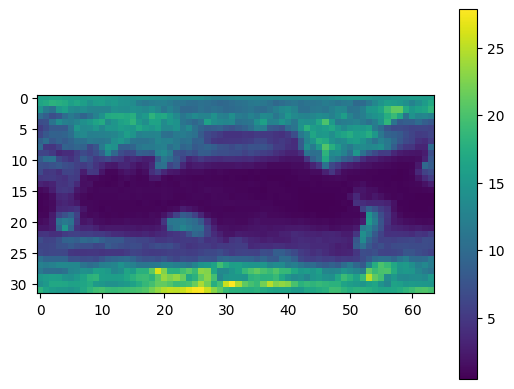

In [207]:
plt.imshow(width_lsci)
plt.colorbar()
plt.show()

In [208]:
## width (CONF)
band_conf = jnp.max(jnp.abs(rval2)[dval_conf > qval_conf], axis = 0).reshape(32, 64)
width_conf = 2 * band_conf

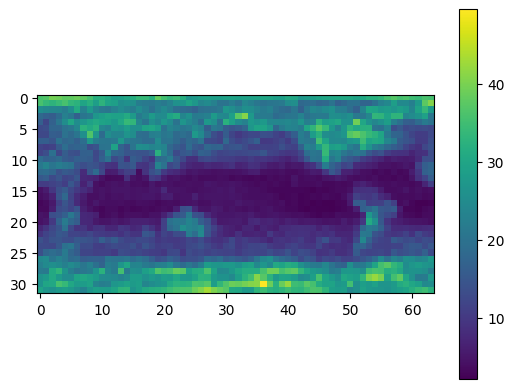

In [209]:
plt.imshow(2 * band_conf)
plt.colorbar()
plt.show()

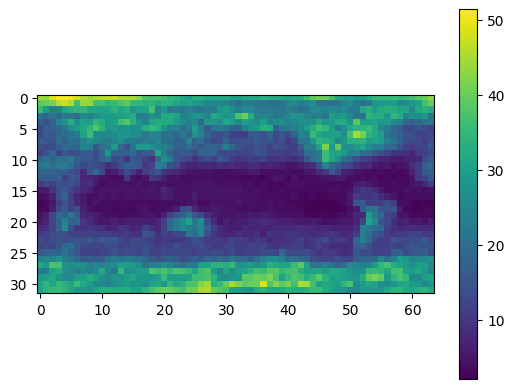

In [210]:
## width (SUPR)
plt.imshow(2 * band_supr.reshape(32, 64))
plt.colorbar()
plt.show()

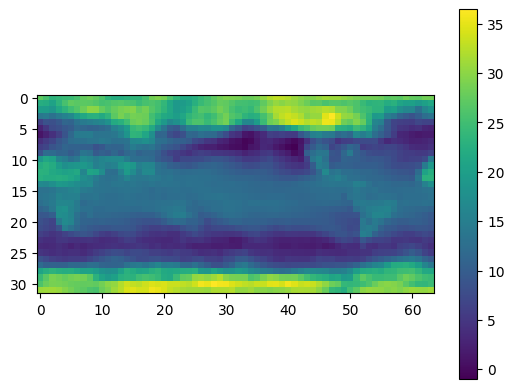

In [211]:
plt.imshow(2 * lam_uqno * ytest_quant[0,:,:,0])
plt.colorbar()
plt.show()

In [212]:
# width_lsci = []

# # rngs = random.split(random.PRNGKey(0), 100)
# rng = random.PRNGKey(0)
# for i in trange(ntest):
#     rng, sub_rng = random.split(rng, 2)
#     rngs = random.split(sub_rng, 100)
#     phi_t = conformal_ens(rngs, rval_proj2, lweight[15423])
#     ens_t = pcax.recover(state, phi_t).reshape(-1, 32, 64)
#     width_lsci.append(jnp.max(ens_t, axis = 0) - jnp.min(ens_t, axis = 0))

# width_lsci = jnp.array(width_lsci)

In [218]:
jnp.median(width_lsci), jnp.median(width_conf), jnp.median(width_supr), jnp.median(2*(lam_uqno * ytest_quant))

(Array(6.8443747, dtype=float32),
 Array(14.826167, dtype=float32),
 Array(15.857814, dtype=float32),
 Array(11.055573, dtype=float32))